In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import time
import cv2
import torch.nn as nn
import torch

img1 = cv2.imread('donald-trump-1.jpg')
img2 = cv2.imread('donald-trump-2.jpg')

#Oriented FAST and Rotated BRIEF
orb = cv2.ORB_create(edgeThreshold=3)

# find the keypoints with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], None, flags=2)

plt.imshow(img3)
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
pts1 = cv2.KeyPoint_convert(kp1)
pts2 = cv2.KeyPoint_convert(kp2)
print(dir(matches[0]))
print(matches[0].trainIdx)
print(matches[0].queryIdx)

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']
470
472


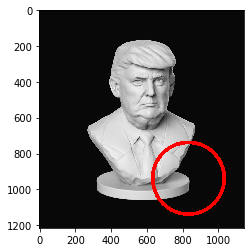

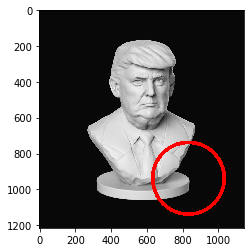

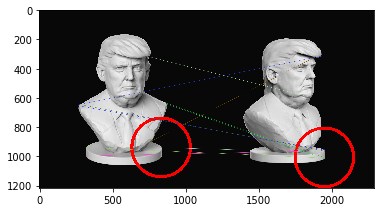

[[838.46454 938.79364]]
[[ 806.21594 1006.8741 ]]


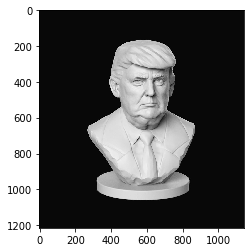

In [3]:
imageA = img1.copy()
imageB = img2.copy()
imageA = cv2.circle(imageA , (835, 938), 200, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
imageB = cv2.circle(imageB , (806, 1006), 200, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
img4 = cv2.drawMatches(imageA, kp1, imageB, kp2, matches[:10], None, flags=2)
plt.imshow(img4)
plt.show()
print(cv2.KeyPoint_convert([kp1[matches[0].trainIdx]]))
print(cv2.KeyPoint_convert([kp2[matches[0].queryIdx]]))

plt.imshow(img1)
plt.show()

In [4]:
import random
import scipy.linalg

#Normalized 8-point algorithm

class LinearLeastSquaresModel():
    """linear system solved using linear least squares

    This class serves as an example that fulfills the model interface
    needed by the ransac() function.

    """

    def __init__(self, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device    
        self.MSE = nn.MSELoss(reduction='none')
        #value will be assigned after calling fit
        self.x = None
        
    def fit(self, data, T1, T2):
        _, _, Vh = scipy.linalg.svd(data)
        #(Hermitian) transpose back
        x = Vh.transpose()[:, -1];
        U, D, Vh = scipy.linalg.svd(x.reshape((3, 3)))
        F = U @ np.diag(np.array([D[1], D[2], 0])) @ Vh
        F = T2.transpose() @ F @ T1
        self.x = torch.tensor(F).view(9).to(self.device);
        return F
    
    def calc_err(self, data):
        batch_size = data.shape[0]
        compute_result = (data @ self.x)
        err = self.MSE(compute_result, torch.zeros((batch_size), dtype=torch.float64).to(self.device))
        return err

def EstimateFundamentalMatrix(sample_points, T1, T2, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    LSmodel = LinearLeastSquaresModel(device = device)
    F = LSmodel.fit(np.array(sample_points), T1, T2)
 
    return F, LSmodel    
    


def convert2Homogeneous(a):
    temp = np.zeros((3,len(a)))
    for i in range(len(a)):
        x1 = a[i][0]
        y1 = a[i][1]
        temp[0][i] = x1
        temp[1][i] = y1
        temp[2][i] = 1
    return temp

def normalise2dpts(pts):
    """
    based on http://pydoc.net/ippe/0.0.1/ippe.homo2d/
    Function translates and normalises a set of 2D homogeneous points 
    so that their centroid is at the origin and their mean distance from 
    the origin is sqrt(2).  This process typically improves the
    conditioning of any equations used to solve homographies, fundamental
    matrices etc.
       
       
    Inputs:
    pts: 3xN array of 2D homogeneous coordinates
   
    Returns:
    newpts: 3xN array of transformed 2D homogeneous coordinates.  The
            scaling parameter is normalised to 1 unless the point is at
            infinity. 
    T: The 3x3 transformation matrix, newpts = T*pts
    """
    if pts.shape[0] != 3:
        print("Input shoud be 3")

    finiteind = np.nonzero(abs(pts[2,:]) > np.spacing(1));
    
    if len(finiteind) != pts.shape[1]:
        print('WARNING(normalise2dpts): Some points are at infinity')
    
    dist = []
    for i in finiteind:
        pts[0,i] = pts[0,i]/pts[2,i]
        pts[1,i] = pts[1,i]/pts[2,i]
        pts[2,i] = 1;

        c = np.mean(pts[0:2,i].T, axis=0).T          

        newp1 = pts[0,i]-c[0]
        newp2 = pts[1,i]-c[1]
    
        dist.append(np.sqrt(newp1**2 + newp2**2))

    meandist = np.mean(dist[:])
    
    scale = np.sqrt(2)/meandist
    
    T = np.array([[scale, 0, -scale*c[0]], [0, scale, -scale*c[1]], [0, 0, 1]])
    
    newpts = T.dot(pts)
    return [newpts, T]

def transform(a,b):
    #####
    #input shape: [batch, [x, y, 1]]
    #return: list 
    #        shape: [batch, [x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1]]
    #####
    mat = []
    assert(len(a)==len(b))
    for i in range(len(a)):
        x1 = a[i][0]
        y1 = a[i][1]
        x2 = b[i][0]
        y2 = b[i][1]
        mat.append([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1])
    return mat

    
def RANSAC(trainPoints, queryPoints, max_iter_times = 1000000, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    
    t = time.time()
    x1, T1 = normalise2dpts(convert2Homogeneous(trainPoints))
    x2, T2 = normalise2dpts(convert2Homogeneous(queryPoints))
    data = transform(x1.transpose(), x2.transpose())
    
    iterations = 0
    batches = torch.tensor(data, dtype=torch.float64).to(device)
    
    batch_size = batches.shape[0]
    
    episilon = batches.new_full((1, batch_size), 0.01).view(batch_size).to(device)
    train_inliers = []
    query_inliers = []
    
    while iterations < max_iter_times:

        sample_points = random.sample(data, 8)
        F, LSmodel = EstimateFundamentalMatrix(sample_points, T1, T2, device)
        err = LSmodel.calc_err(batches)
        if((err < episilon).float().mean().item() > 0.95):           
            ind = np.where((err.cpu()<episilon.cpu()))
            train_inliers = trainPoints[ind]
            query_inliers = queryPoints[ind]
            break
        iterations += 1
        
    print('[RANSAC] takes ', time.time() - t,'sec')
    print('[RANSAC] iteration', iterations,' err:', err.mean().item())     
    if(iterations == max_iter_times):
        print("no result found by RANSAC")
    
    return F, train_inliers, query_inliers, ind

In [6]:
trainPoints = cv2.KeyPoint_convert([kp1[matches[i].trainIdx] for i in range(len(matches))])
queryPoints = cv2.KeyPoint_convert([kp2[matches[i].queryIdx] for i in range(len(matches))])
F, train_inliers, query_inliers, ind = RANSAC(trainPoints, queryPoints, max_iter_times = 1000000)
#print(F)


WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.06864023208618164 sec
[RANSAC] iteration 107  err: 0.006488612798817303


In [7]:
print(np.array(train_inliers).shape)


(94, 2)


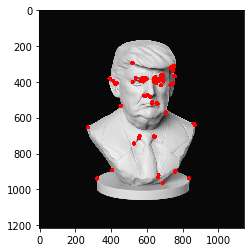

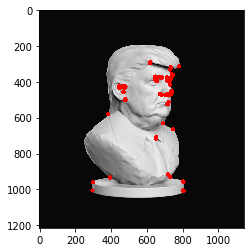

In [12]:
imageA = img1.copy()
imageB = img2.copy()
for i in train_inliers:
    imageA = cv2.circle(imageA , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
for i in query_inliers:
    imageB = cv2.circle(imageB , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
plt.imshow(imageB)
plt.show()


In [ ]:
# def sift_feature(image, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
#     print("image shape:",image.shape, )
#     h,w = image.shape
#     patch_size = min([h,w])
#     patch = image[:patch_size, :patch_size]#image[h//4: h//4 + patch_size,w//3 : w//3 + patch_size]
#     # It takes n_patches x 1 x patch_size x patch_size input == standard pytorch batch format
#     patches = np.ndarray((1, 1, patch_size, patch_size), dtype=np.float32)
#     patches[0,0,:,:] = patch
        
#     SIFT = SIFTNet(patch_size = patch_size).to(device)
#     SIFT.eval()
    
#     t = time.time()
#     with torch.no_grad():       
#         torch_patches = torch.from_numpy(patches).cuda()
#         res = SIFT(torch_patches)
#         print(res)
#         sift = np.round(512. * res.data.cpu().numpy()).astype(np.int32)

#     print ('device:',device)
#     print(' time', time.time() - t)   
#     plt.figure()
#     plt.imshow(patch, cmap="gray")
#     return sift